# Comparative study from hospitals 

<u>**Goal:**</u> Development of an Automated Machine Learning-based Model for Epileptogenic Zone Localization: A Comparative Study from Hospitals in Brno and Montreal

13/3/2023

## Data Preparation 

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# Import dataset

df = pd.read_csv('~/Marek/2_PhD/ISI/Work/data/new_isi_data.csv')
# Remove unnamed column: ,index_col=0
df.head()

,Unnamed: 0,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [3]:
# Drop index column

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,power_4.0-8.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,0.781969,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,0.780688,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,0.740345,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,0.721173,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,0.937518,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [4]:
# Drop "nan" channels across all segments

df_nans = df[df.isnull().any(axis=1)]
for pts in df_nans.patient_id.unique():
    for chns in list(df_nans.loc[df_nans.patient_id == pts,'channel_name'].unique()):
        df = df.drop(df[(df.patient_id == pts) & (df.channel_name == chns)].index)

In [5]:
# Dataframe preparation, target column 

outcome_11 = 11

df = df[df.outcome <= outcome_11]
mask = df.onset_channel == 'NON_SOZ'
df.loc[mask, 'onset_channel'] = 0
mask = df.onset_channel == 'SOZ'
df.loc[mask, 'onset_channel'] = 1

# Convert onset_channel column to numeric
df['onset_channel'] = pd.to_numeric(df['onset_channel'])

tmp = df['resected'].values * df['onset_channel'].values
df['target'] = tmp.astype(int)
df = df.rename(columns={'spike_rate':'spike_rate_0.0-0.0',
                        'pse':'pse_0.0-0.0',
                        'pac':'pac_0.0-0.0',
                        'fac':'fac_0.0-0.0',
                        'lfr':'lfr_0.0-0.0'})

features = [x for x in df if any(c.isdigit() for c in x)]
features.sort()

In [6]:
# Drop no target pts

target = 'target'
for pts in df.patient_id.unique():
    if sum(df.loc[df.patient_id == pts,target]) == 0:
        #print('patient',str(pts),'does not have target - droping this patient')
        df = df[df.patient_id != pts]

In [7]:
# Scale selected features with standard scaler (z-score)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder        
scaler = StandardScaler()
for pts in df.patient_id.unique(): 
    df.loc[df.patient_id == pts,features] = scaler.fit_transform(df.loc[df.patient_id == pts,features])

In [8]:
# Keep only segm_type = 4 

df = df.loc[df['segm_type'] == 4]
print(df.shape)
df.head()

(1959, 68)


,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,...,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target
34674,583,ra1,0,0,11.0,0.154341,0.251976,0.434666,-0.313875,-0.646958,...,-0.111063,0.012941,0.116559,-1.559751,0.818857,-1.716212,-1.580468,4,0,0
34675,583,ra2,0,0,11.0,1.007100,0.378555,1.161338,-0.219707,-0.514371,...,-0.407842,0.548060,0.527341,0.211685,-0.107760,0.117977,0.188793,4,0,0
34676,583,ra3,0,0,11.0,1.060397,0.462940,1.464118,-0.225449,-0.489855,...,-0.402662,0.543243,0.525717,0.185927,-0.174275,0.081883,0.154040,4,0,0
34677,583,ra4,0,0,11.0,1.646670,0.462940,1.484303,-0.238317,-0.506518,...,-0.259716,0.277280,0.341714,-0.171466,0.152053,-0.256124,-0.161492,4,0,0
34678,583,ra5,0,0,11.0,0.847208,0.652809,1.363191,0.019663,-0.361414,...,-0.060966,-0.324808,-0.177319,0.122580,-0.200588,0.013757,0.090686,4,0,0


In [9]:
# Number of unique patients

print(len(df.patient_id.unique()))
patients = df.patient_id.unique()
patients = np.sort(patients)
patients

18


array([  61,   63,   71,   77,   82,   89,   93,  583,  657,  717,  723,
        953,  965, 1002, 1021, 1041, 1043, 1630])

In [10]:
# Country column

df.loc[df['patient_id'] < 100 , 'country'] = 'Brno' 
df.loc[df['patient_id'] > 100 , 'country'] = 'Montreal' 
df.head()

,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,...,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target,country
34674,583,ra1,0,0,11.0,0.154341,0.251976,0.434666,-0.313875,-0.646958,...,0.012941,0.116559,-1.559751,0.818857,-1.716212,-1.580468,4,0,0,Montreal
34675,583,ra2,0,0,11.0,1.007100,0.378555,1.161338,-0.219707,-0.514371,...,0.548060,0.527341,0.211685,-0.107760,0.117977,0.188793,4,0,0,Montreal
34676,583,ra3,0,0,11.0,1.060397,0.462940,1.464118,-0.225449,-0.489855,...,0.543243,0.525717,0.185927,-0.174275,0.081883,0.154040,4,0,0,Montreal
34677,583,ra4,0,0,11.0,1.646670,0.462940,1.484303,-0.238317,-0.506518,...,0.277280,0.341714,-0.171466,0.152053,-0.256124,-0.161492,4,0,0,Montreal
34678,583,ra5,0,0,11.0,0.847208,0.652809,1.363191,0.019663,-0.361414,...,-0.324808,-0.177319,0.122580,-0.200588,0.013757,0.090686,4,0,0,Montreal


In [11]:
# Split epilepsy dataset to Montreal & Brno dataframe

df_montreal, df_brno = [x for _, x in df.groupby(df['patient_id'] < 100)]

In [12]:
# Oversampling method used to handle imbalanced datasets for df_montreal

from imblearn.over_sampling import SMOTE

# Separate features and target
X = df_montreal[features]
y = df_montreal[target]

# Perform SMOTE oversampling on the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_resampled_montreal = pd.concat([pd.DataFrame(X_resampled, columns=features), pd.DataFrame(y_resampled, columns=[target])], axis=1)

# Print the shape of the original and resampled datasets
print('Original dataset shape:', df_montreal.shape)
print('Resampled dataset shape:', df_resampled_montreal.shape)

Original dataset shape: (937, 69)
Resampled dataset shape: (1690, 61)


In [13]:
# Oversampling method used to handle imbalanced datasets for df_brno

from imblearn.over_sampling import SMOTE

# Separate features and target
X = df_brno[features]
y = df_brno[target]

# Perform SMOTE oversampling on the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_resampled_brno = pd.concat([pd.DataFrame(X_resampled, columns=features), pd.DataFrame(y_resampled, columns=[target])], axis=1)

# Print the shape of the original and resampled datasets
print('Original dataset shape:', df_brno.shape)
print('Resampled dataset shape:', df_resampled_brno.shape)

Original dataset shape: (1022, 69)
Resampled dataset shape: (1956, 61)


## Exploratory Data Analysis

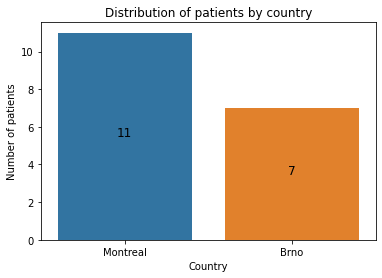

In [14]:
# Distribution of patients by country

sns.countplot(x='country', data=df.drop_duplicates(subset='patient_id'))
plt.title('Distribution of patients by country')
plt.xlabel('Country')
plt.ylabel('Number of patients')

# Get the count for each country
counts = df.drop_duplicates(subset='patient_id')['country'].value_counts()

# Add text labels to the top of each bar
for i, count in enumerate(counts):
    plt.annotate(str(count), xy=(i, count/2), ha='center', fontsize=12)

plt.show()


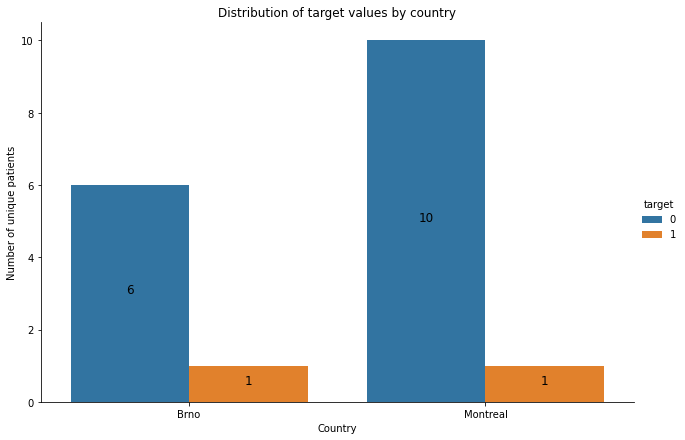

In [15]:
# Distribution of target values by country 

# Group data by country and target, count unique patients
grouped = df.drop_duplicates(subset='patient_id').groupby(['country', 'target'])['patient_id'].nunique().reset_index()

# Plot count of unique patients with each target value for each country
sns.catplot(x='country', y='patient_id', hue='target', kind='bar', data=grouped, height=6, aspect=1.5)
plt.title('Distribution of target values by country')
plt.xlabel('Country')
plt.ylabel('Number of unique patients')

# Add text labels to each bar
for i, country in enumerate(grouped['country'].unique()):
    for j, target in enumerate(grouped['target'].unique()):
        count = grouped[(grouped['country']==country) & (grouped['target']==target)]['patient_id'].values
        if j == 0:
            plt.annotate(str(count[0]), xy=(i-0.2, count/2), ha='center', fontsize=12, color='black')
        else:
            plt.annotate(str(count[0]), xy=(i+0.2, count/2), ha='center', fontsize=12, color='black')

plt.show()



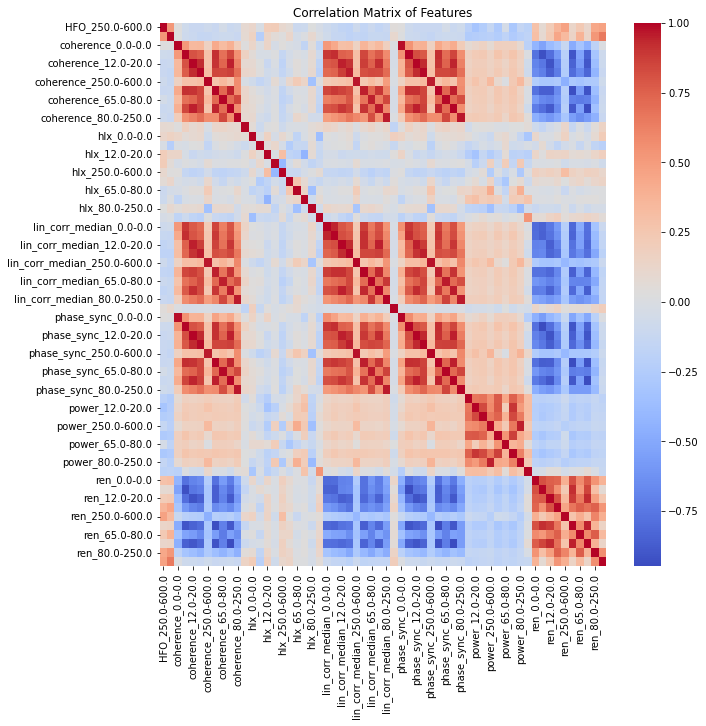

In [16]:
# Correlation Matrix of Features

# Generate correlation matrix
corr_matrix = df[features].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()



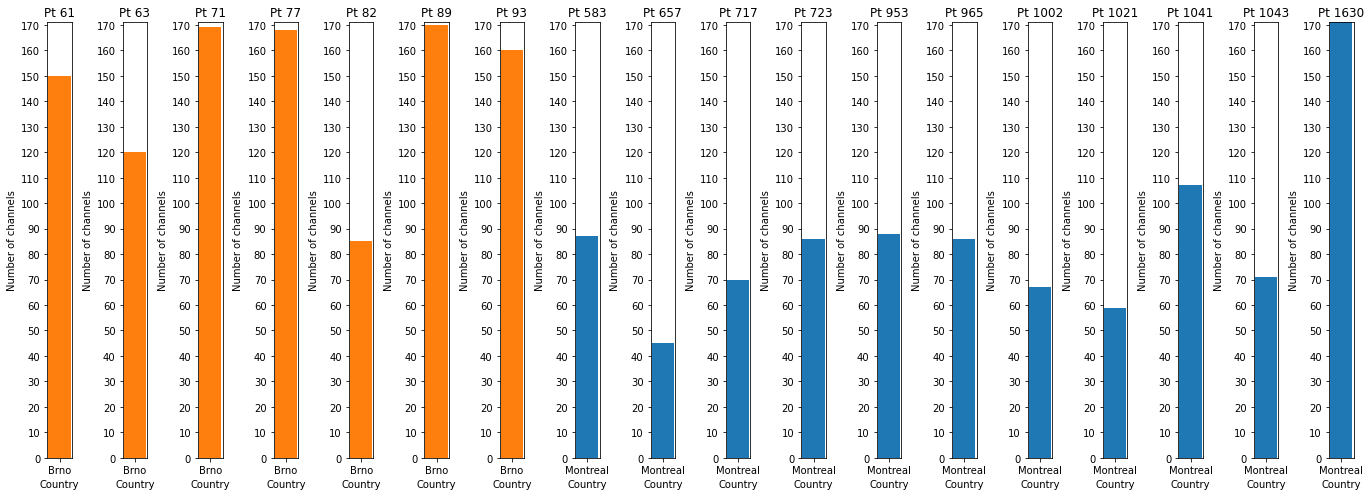

In [17]:
# Number of channels per patient and country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("country").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    ax.bar(grouped["country"], grouped["count"], color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of channels")
    max_count = max(max_count, grouped["count"].max())

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, max_count, 10))
    ax.set_yticklabels(range(0, max_count, 10))
   
    
plt.tight_layout()
plt.show()


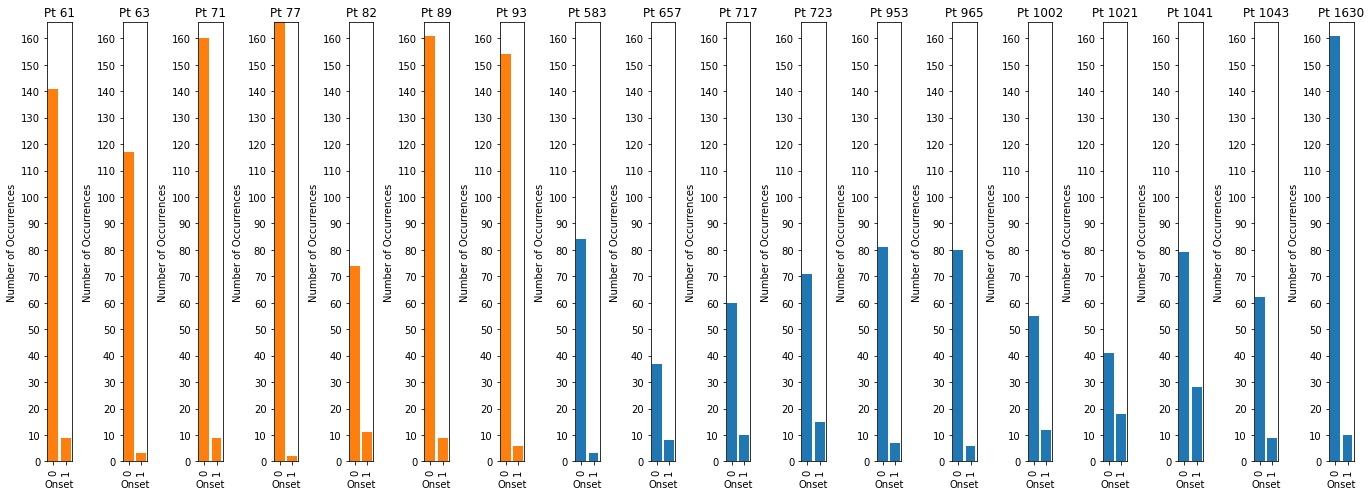

In [18]:
# Number of onset channels per patient per country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their onset channel data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("onset_channel").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    # Convert the onset channel to categorical data type and specify a fixed width of 0.8
    ax.bar(grouped["onset_channel"], grouped["count"], width=0.8, color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Onset")
    ax.set_ylabel("Number of Occurrences")
    
    # Rotate the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    
    max_count = max(max_count, grouped["count"].max())

    # Set y-axis tick marks and labels
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, 170, 10))
    ax.set_yticklabels(range(0, 170, 10))

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()


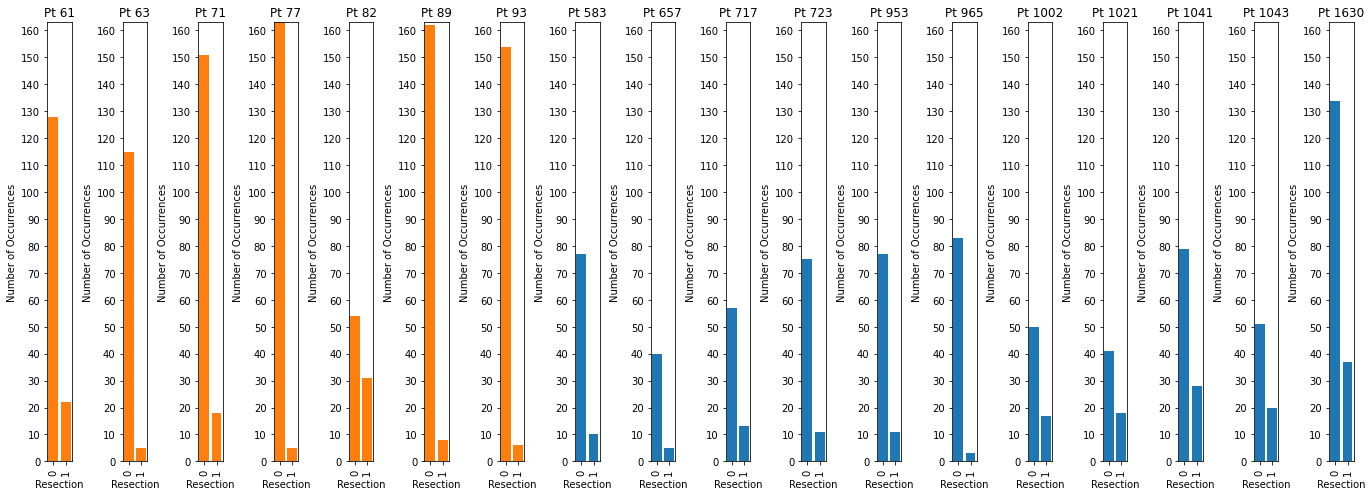

In [19]:
# Number of resection per patient per country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their resected data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("resected").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    # Convert the resected variable to categorical data type and specify a fixed width of 0.8
    ax.bar(grouped["resected"], grouped["count"], width=0.8, color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Resection")
    ax.set_ylabel("Number of Occurrences")
    
    # Rotate the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    
    max_count = max(max_count, grouped["count"].max())

    # Set y-axis tick marks and labels
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, 170, 10))
    ax.set_yticklabels(range(0, 170, 10))

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()


## Comparative study of publicly available AutoML models

In [20]:
# TPOT Classifier for df_resampled_brno

# import necessary libraries
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_brno

# separate features and target
X = df_resampled_brno.drop(['target'], axis=1)
y = df_resampled_brno['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the TPOT model
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# evaluate the model
y_pred = tpot.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9802705810005079

Generation 2 - Current best internal CV score: 0.9802705810005079

Generation 3 - Current best internal CV score: 0.9868479452421057

Generation 4 - Current best internal CV score: 0.9868559664180102

Generation 5 - Current best internal CV score: 1.0

Best pipeline: ExtraTreesClassifier(PCA(input_matrix, iterated_power=4, svd_solver=randomized), bootstrap=False, criterion=gini, max_features=0.7500000000000001, min_samples_leaf=6, min_samples_split=8, n_estimators=100)
Sensitivity: 1.0
Specificity: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Precision-Recall AUC: 1.0


In [21]:
# TPOT Classifier for df_resampled_montreal 

# import necessary libraries
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_montreal

# separate features and target
X = df_resampled_montreal.drop(['target'], axis=1)
y = df_resampled_montreal['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the TPOT model
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# evaluate the model
y_pred = tpot.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9594328827862404

Generation 2 - Current best internal CV score: 0.9628119859829793

Generation 3 - Current best internal CV score: 0.9687334620610741

Generation 4 - Current best internal CV score: 0.9687334620610741

Generation 5 - Current best internal CV score: 0.9687334620610741

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=7, max_features=0.5, min_samples_leaf=19, min_samples_split=10, n_estimators=100, subsample=0.8500000000000001)
Sensitivity: 0.9961389961389961
Specificity: 0.9556451612903226
Accuracy: 0.9763313609467456
Precision: 0.9591078066914498
Recall: 0.9961389961389961
Precision-Recall AUC: 0.9786095947091085


In [22]:
# Autokeras for df_resampled_brno

# import necessary libraries
import pandas as pd
import numpy as np
import autokeras as ak
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_brno 

# separate features and target
X = df_resampled_brno.drop(['target'], axis=1)
y = df_resampled_brno['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the Auto-Keras model
clf = ak.StructuredDataClassifier(max_trials=10)
clf.fit(X_train, y_train, epochs=10)

# evaluate the model
y_pred = clf.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


2023-03-13 17:42:05.857973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:42:05.992906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 17:42:05.992924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 17:42:06.014596: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 17:42:06.486140: W tensorflow/stream_executor/platform/de

INFO:tensorflow:Reloading Tuner from ./structured_data_classifier/tuner0.json


2023-03-13 17:42:07.081478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 17:42:07.081501: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 17:42:07.081517: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lenovo): /proc/driver/nvidia/version does not exist
2023-03-13 17:42:07.081739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Oracle triggered exit
Epoch 1/10
43/43 [==============================] - 1s 3ms/step - loss: 0.4672 - accuracy: 0.7860
Epoch 2/10
43/43 [==============================] - 0s 2ms/step - loss: 0.2445 - accuracy: 0.9204
Epoch 3/10
43/43 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.9598
Epoch 4/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9817
Epoch 5/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9898
Epoch 6/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9956
Epoch 7/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9978
Epoch 8/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 9/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 10/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 

In [23]:
# Autokeras for df_resampled_montreal

# import necessary libraries
import pandas as pd
import numpy as np
import autokeras as ak
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_montreal

# separate features and target
X = df_resampled_montreal.drop(['target'], axis=1)
y = df_resampled_montreal['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the Auto-Keras model
clf = ak.StructuredDataClassifier(max_trials=10)
clf.fit(X_train, y_train, epochs=10)

# evaluate the model
y_pred = clf.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


INFO:tensorflow:Reloading Tuner from ./structured_data_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
37/37 [==============================] - 1s 2ms/step - loss: 0.4607 - accuracy: 0.7853
Epoch 2/10
37/37 [==============================] - 0s 2ms/step - loss: 0.2517 - accuracy: 0.9079
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9332
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 0.1450 - accuracy: 0.9493
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9653
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9721
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9806
Epoch 8/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9822
Epoch 9/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.9865
Ep

In [24]:
# Autosklearn for df_resampled_brno

# import necessary libraries
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import autosklearn.classification

# load the data
df_resampled_brno

# separate features and target
X = df_resampled_brno.drop(['target'], axis=1)
y = df_resampled_brno['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the Auto-Sklearn model
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120, n_jobs=-1)
clf.fit(X_train, y_train)

# evaluate the model
y_pred = clf.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


[WARNING] [2023-03-13 17:42:30,330:Client-AutoML(1):03d95dd0-c1be-11ed-83b1-811c70bbcd78] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (119.670966)
[WARNING] [2023-03-13 17:42:30,330:Client-AutoML(1):03d95dd0-c1be-11ed-83b1-811c70bbcd78] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.
[WARNING] [2023-03-13 17:43:25,199:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2023-03-13 17:43:25,360:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2023-03-13 17:43:25,522:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2023-03-13 17:43:25,756:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got 

In [25]:
# Autosklearn for df_resampled_montreal

# import necessary libraries
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import autosklearn.classification

# load the data
df_resampled_montreal

# separate features and target
X = df_resampled_montreal.drop(['target'], axis=1)
y = df_resampled_montreal['target']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the Auto-Sklearn model
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120, n_jobs=-1)
clf.fit(X_train, y_train)

# evaluate the model
y_pred = clf.predict(X_test)

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)


[WARNING] [2023-03-13 17:44:39,504:Client-AutoML(1):51c05c06-c1be-11ed-83b1-811c70bbcd78] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (119.732939)
[WARNING] [2023-03-13 17:44:39,504:Client-AutoML(1):51c05c06-c1be-11ed-83b1-811c70bbcd78] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.
Sensitivity: 1.0
Specificity: 0.907258064516129
Accuracy: 0.9546351084812623
Precision: 0.9184397163120568
Recall: 1.0
Precision-Recall AUC: 0.9592198581560284


In [26]:
# H2o.automl for df_resampled_brno

# import necessary libraries
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_brno

# initialize H2O
h2o.init()

# convert data to H2O Frame
data = h2o.H2OFrame(df_resampled_brno)

# identify predictors and response
x = data.columns[:-1]
y = "target"
data[y] = data[y].asfactor()

# split the data into training and testing sets
train, test = data.split_frame(ratios=[0.7], seed=42)

# train the H2O AutoML model
aml = H2OAutoML(max_runtime_secs=120, seed=42)
aml.train(x=x, y=y, training_frame=train)

# evaluate the model
perf = aml.leader.model_performance(test)
y_pred = aml.leader.predict(test).as_data_frame()['predict']

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(test[y].as_data_frame().values, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(test[y].as_data_frame().values, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)

# shut down H2O
h2o.shutdown()


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /home/marek/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpal4t1hxs
  JVM stdout: /tmp/tmpal4t1hxs/h2o_marek_started_from_python.out
  JVM stderr: /tmp/tmpal4t1hxs/h2o_marek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_marek_ela4w7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.742 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Sensitivity: 0.9890510948905109
Specificity: 0.979933110367893
Accuracy: 0.9842931937172775
Precision: 0.9783393501805054
Recall: 0.9890510948905109
Precision-Recall AUC: 0.9863130235826286
H2O session _sid_92bd closed.


/tmp/ipykernel_66481/2111120456.py:56: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [28]:
# H2o.automl for df_resampled_montreal

# import necessary libraries
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

# load the data
df_resampled_montreal

# initialize H2O
h2o.init()

# convert data to H2O Frame
data = h2o.H2OFrame(df_resampled_montreal)

# identify predictors and response
x = data.columns[:-1]
y = "target"
data[y] = data[y].asfactor()

# split the data into training and testing sets
train, test = data.split_frame(ratios=[0.7], seed=42)

# train the H2O AutoML model
aml = H2OAutoML(max_runtime_secs=120, seed=42)
aml.train(x=x, y=y, training_frame=train)

# evaluate the model
perf = aml.leader.model_performance(test)
y_pred = aml.leader.predict(test).as_data_frame()['predict']

# calculate sensitivity, specificity, accuracy, and precision-recall curves
tn, fp, fn, tp = confusion_matrix(test[y].as_data_frame().values, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision, recall, _ = precision_recall_curve(test[y].as_data_frame().values, y_pred)
pr_auc = auc(recall, precision)

# calculate precision and recall
precision_value = tp / (tp + fp)
recall_value = tp / (tp + fn)

# print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision_value)
print("Recall:", recall_value)
print("Precision-Recall AUC:", pr_auc)

# shut down H2O
h2o.shutdown()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /home/marek/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpawt_8r65
  JVM stdout: /tmp/tmpawt_8r65/h2o_marek_started_from_python.out
  JVM stderr: /tmp/tmpawt_8r65/h2o_marek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_marek_xwcmm9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.742 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Sensitivity: 0.9914893617021276
Specificity: 0.9494163424124513
Accuracy: 0.9695121951219512
Precision: 0.9471544715447154
Recall: 0.9914893617021276
Precision-Recall AUC: 0.9713544369486249
H2O session _sid_8222 closed.


/tmp/ipykernel_66481/3855806078.py:56: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
